## Описание проекта
Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.  
Чтобы бороться с оттоком, отдел по работе с клиентами перевёл в электронный вид множество клиентских анкет.  
Информация с данными предоставлена, основная задача — провести анализ и подготовить план действий по удержанию клиентов.  

А именно:  
1. Спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;  
2. Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;  
3. Проанализировать основные признаки, наиболее сильно влияющие на отток;  
4. Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:  
    4.1. выделить целевые группы клиентов;  
    4.2. предложить меры по снижению оттока;  
    4.3. определить другие особенности взаимодействия с клиентами.

## Описание данных
Набор данных включает следующие поля.  

**Данные клиента за предыдущий до проверки факта оттока месяц:**  
`gender` — пол;  
`Near_Location` — проживание или работа в районе, где находится фитнес-центр;  
`Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);  
Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);  
`Phone` — наличие контактного телефона;  
`Age` — возраст;  
`Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).  

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**  
`Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);  
`Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);  
`Group_visits` — факт посещения групповых занятий;  
`Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;  
`Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;  
`Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.  

`Churn` — факт оттока в текущем месяце.

## Шаг 1. Загружаем данные.

In [ ]:
import pandas as pd
import seaborn as sns
import math
import re
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import itertools
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('/datasets/gym_churn.csv')

In [ ]:
display(df.head())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [ ]:
# приведем колонки к нижнему регистру
df.columns = map(str.lower, df.columns)

## Шаг 2. Исследовательский анализ данных (EDA).

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [ ]:
# ищем пропущенные значения:
print(df.isna().sum())

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64


In [ ]:
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm') # % пропущенных значений

,0
gender,0.000000
near_location,0.000000
partner,0.000000
promo_friends,0.000000
phone,0.000000
contract_period,0.000000
group_visits,0.000000
age,0.000000
avg_additional_charges_total,0.000000
month_to_end_contract,0.000000


**Пропущенных значений нет**

In [ ]:
# проверяем на наличие явных дубликатов
print('Явных дубликатов по df:', df.duplicated().sum())

Явных дубликатов по df: 0


In [ ]:
df.describe(include = "all")

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Судя по столбцу **Churn** (факт оттока) и его среднему значению 0,26525, дела у компании не очень.  
Посещаемость (**Avg_class_frequency_total**) тоже низкая, всего 1,87902 в неделю.

In [ ]:
# посмотрим на средние значения признаков в двух группах - тех, кто ушел в отток и тех, кто остался
df_churn = df.groupby('churn').mean().reset_index()
#df_churn.loc[df_churn['Churn'] == 0, 'Churn'] = 'Ушли'
#df_churn.loc[df_churn['Churn'] == 1, 'Churn'] = 'Остались'
display(df_churn)

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


**Наблюдаем следующую картину по наиболее интересным стообцам:**  
1. *gender*. В обоих группах значение около 0,5. Разница примерно 50 на 50 между полом ушел\остался.  
2. *Near_Location*. Оба значения около 0,8. Нет разницы в локации ушел\остался.
3. *Partner*. Отток примерно равен с партнерской программой и без. Остаются же чаще без партнерской программы.
4. *Contract_period*. Уходят в среднем через 5,7 месяца.  
5. *Group_visits*. Посещающие групповые занятия чаще уходят.  
6. *Age*. Средний возраст уходящих около 30 лет, остающихся около 27 лет.  
7. *Avg_additional_charges_total*. Тем, кто уходят больше интересны сопутствующие услуги.
8. *Avg_class_frequency_current_month*. У уходящих посещений до оттока почти в 2 раза больше.

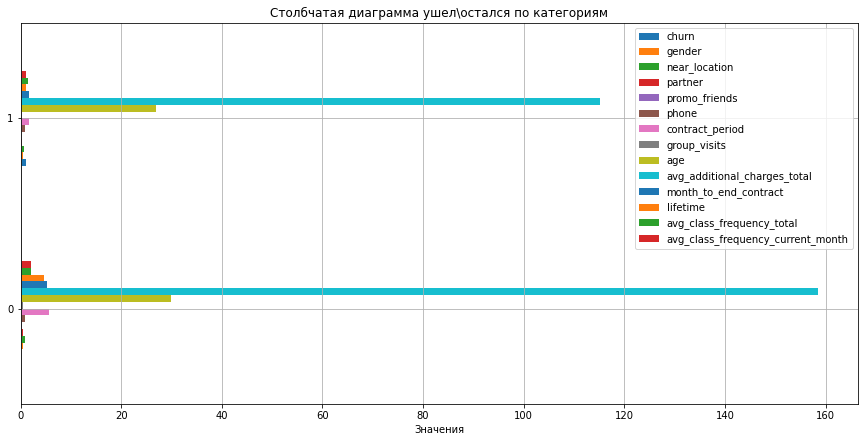

In [ ]:
df_churn.plot(kind = 'barh',figsize = (15, 7), grid = True, title='Столбчатая диаграмма ушел\остался по категориям')
plt.xlabel('Значения')
plt.show()

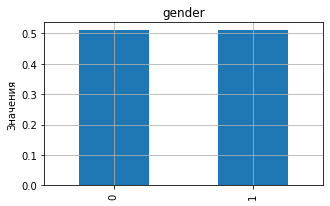

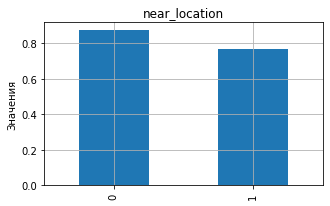

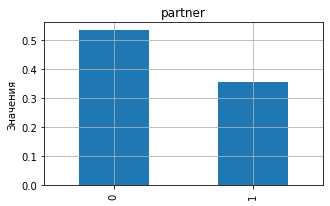

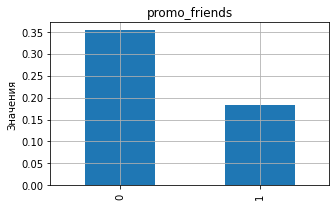

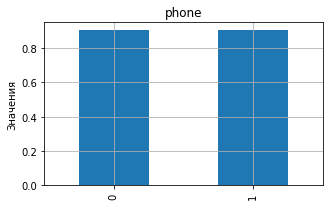

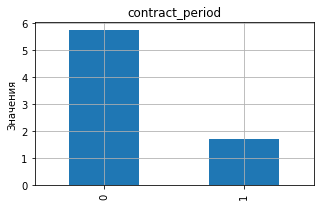

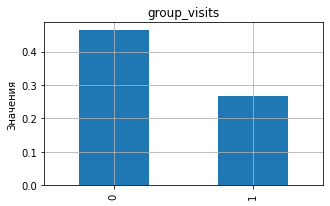

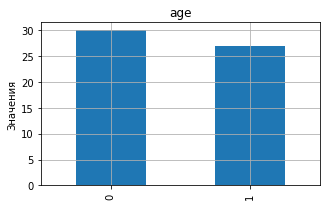

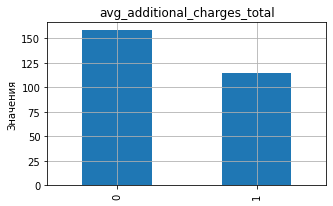

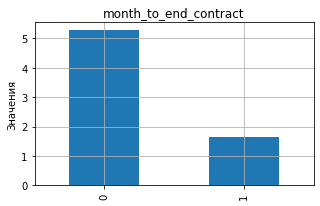

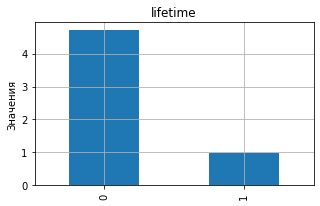

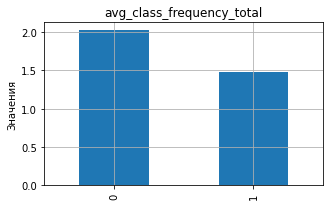

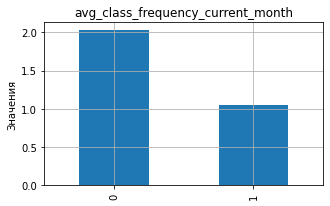

In [ ]:
for col in df_churn.drop('churn', axis = 1).columns:
    plt.rcParams["figure.figsize"] = (5,3)
    plt.title(col)
    plt.ylabel('Значения')
    df_churn[col].plot.bar()
    plt.grid()
    plt.show()

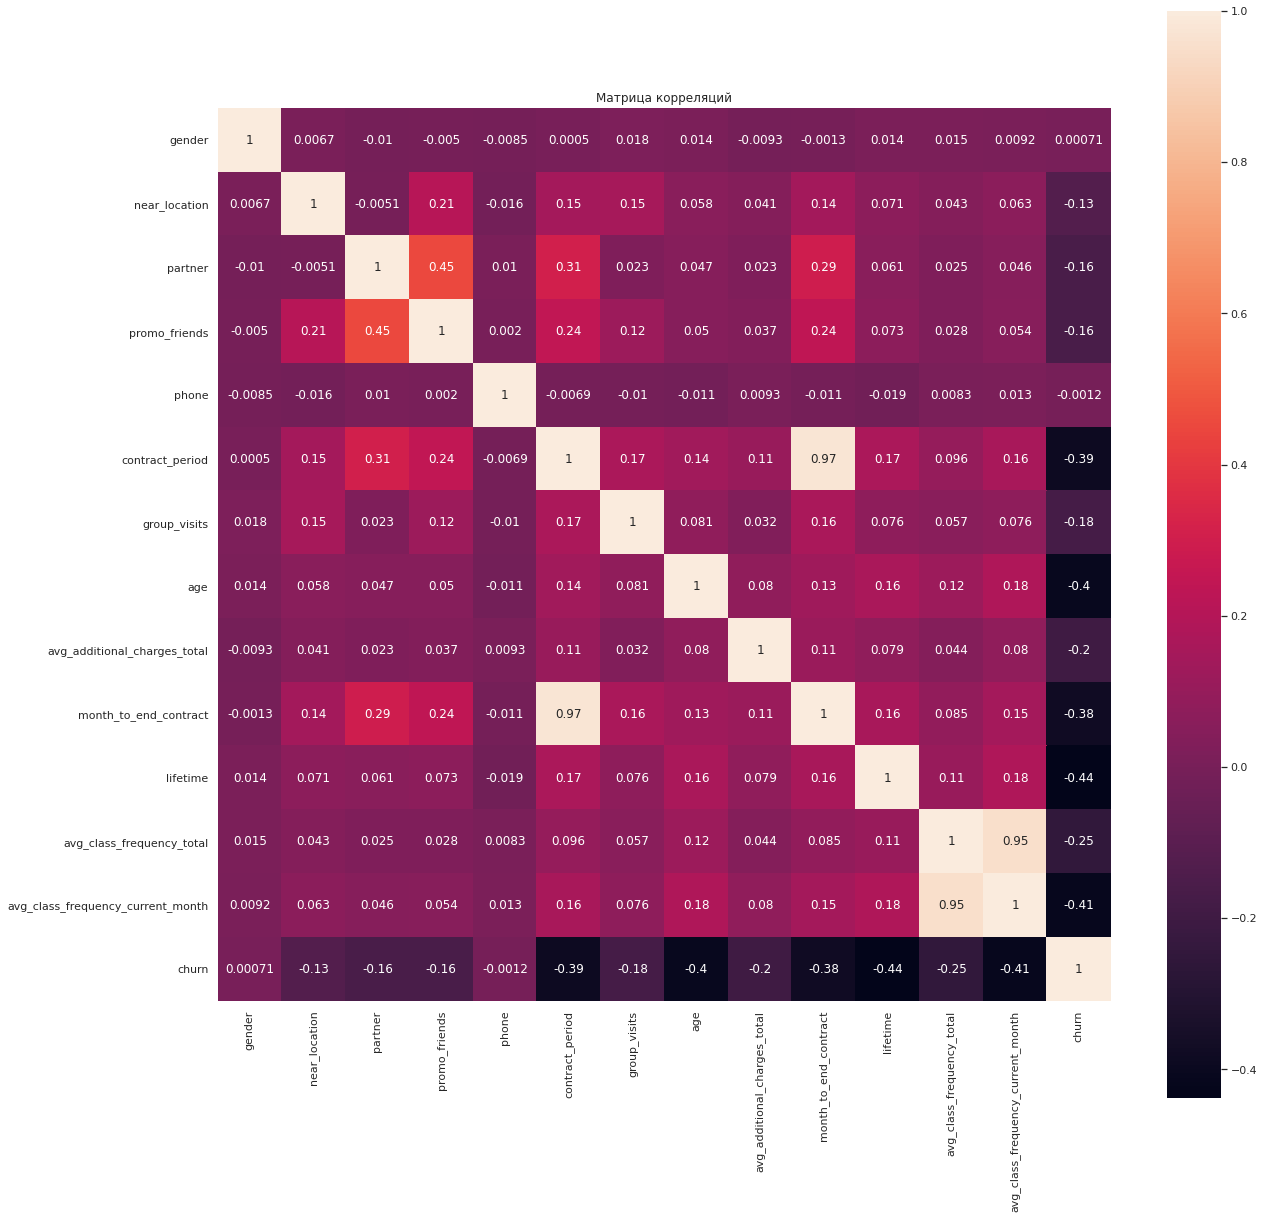

In [ ]:
#построим и отрисуем матрицу корреляций
cm = df.corr() #вычисляем матрицу корреляций
fig, ax = plt.subplots()
#нарисуем тепловую карту с подписями для матрицы корреляций
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(cm, annot = True, square = True).set(title="Матрица корреляций");

## Шаг 3. Строим модель прогнозирования оттока клиентов.

In [ ]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis =1)
y = df['churn']
#разобьем данные на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
# стандартизируем данные и обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)
# Преобразуем обучающие и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [ ]:
# определим функцию, которая будет выводить метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))


In [ ]:
# задаем алгоритм *логистической регрессии*
LR_model = LogisticRegression(solver='liblinear',random_state=0)
# обучаем модель
LR_model.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
LR_predictions = LR_model.predict(X_test_st)
LR_probabilities = LR_model.predict_proba(X_test_st)[:, 1]
# выводим метрики
print_all_metrics(y_test, LR_predictions, LR_probabilities,title='Метрики для модели логистической регрессии:')


Метрики для модели логистической регрессии:
	Accuracy: 0.27
	Precision: 0.27
	Recall: 1.00
	F1: 0.42
	ROC_AUC: 0.92


In [ ]:
# задаем алгоритм *случайного леса*
RF_model = RandomForestClassifier(random_state = 0)
# обучаем модель
RF_model.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = RF_model.predict(X_test_st) # Ваш код здесь
rf_probabilities = RF_model.predict_proba(X_test_st)[:,1]
# выводим метрики
print_all_metrics(y_test, rf_predictions, rf_probabilities, title='Метрики для модели случайного леса:')


Метрики для модели случайного леса:
	Accuracy: 0.28
	Precision: 0.27
	Recall: 1.00
	F1: 0.42
	ROC_AUC: 0.69


**Рассматривая метрики Accuracy, Precision, Recall, F1 модели ведут себя практически одинаково. Однако ROC_AUC у логистической регрессии выше.**

## Шаг 4. Сделаем кластеризацию клиентов

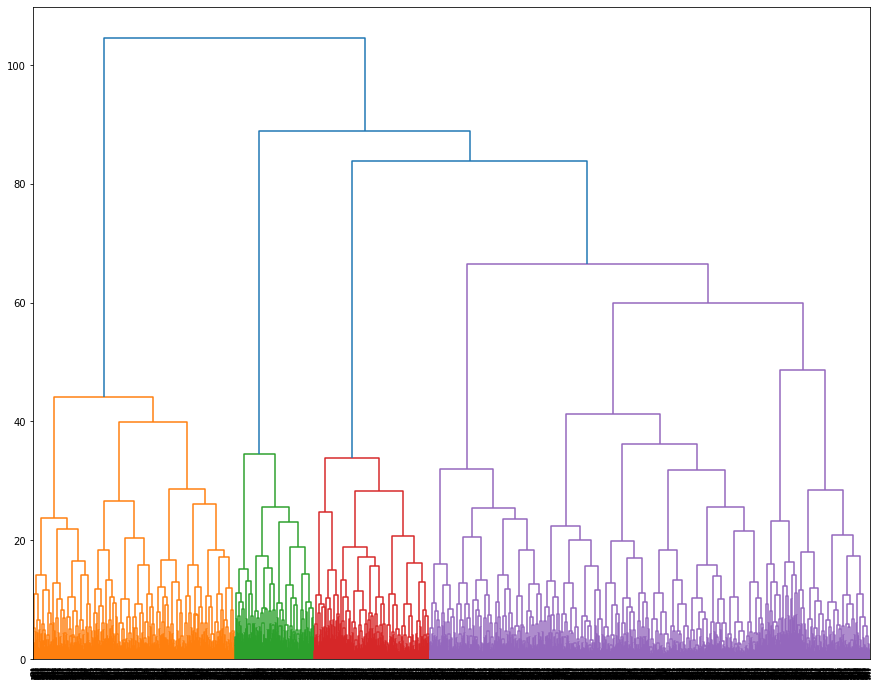

In [ ]:
# построим матрицы расстояний и дендрограмму
# стандартизируем данные перед работой с алгоритмами
df_drop_churn = df.drop('churn', axis = 1)
std_df = scaler.fit_transform(df_drop_churn)
linked = linkage(std_df, method = 'ward')
plt.figure(figsize=(15, 12))
dendrogram(linked, orientation='top')
plt.show()

**Оптимальное число кластеров 4 — четыре разных цвета на графике.**

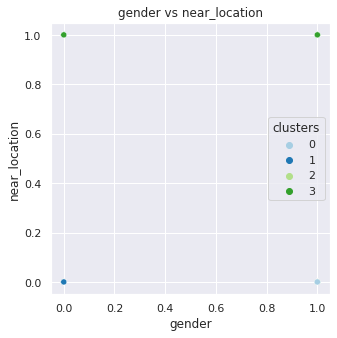

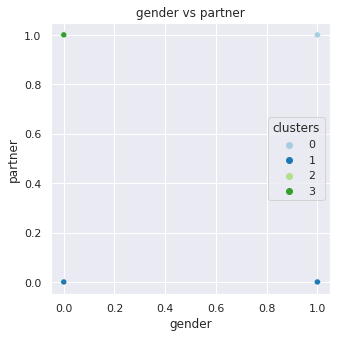

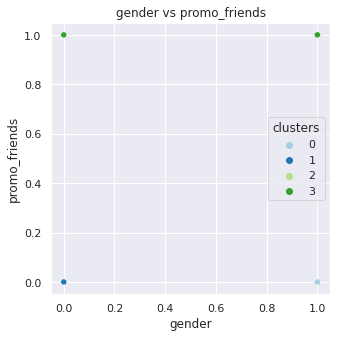

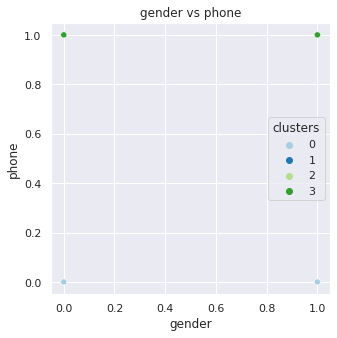

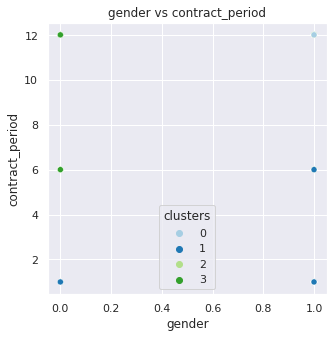

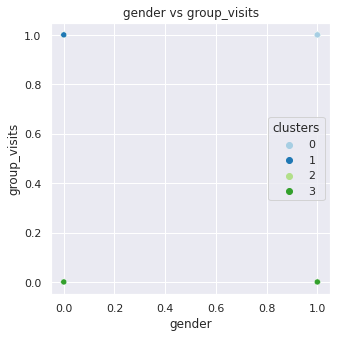

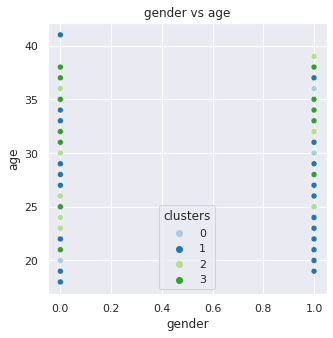

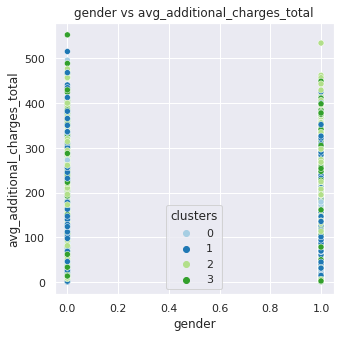

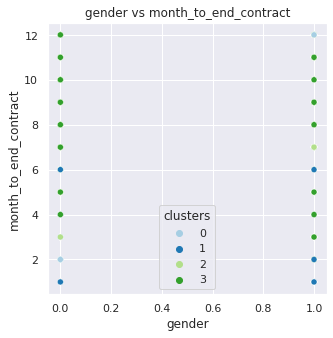

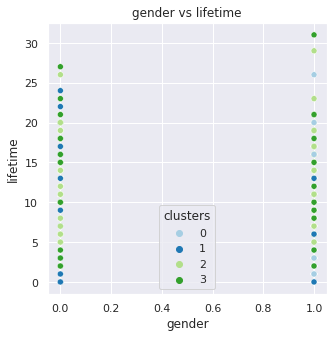

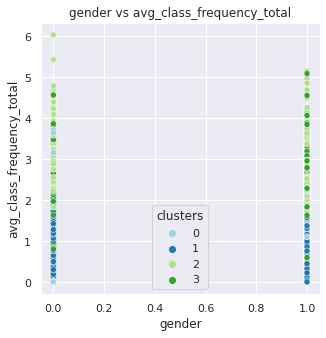

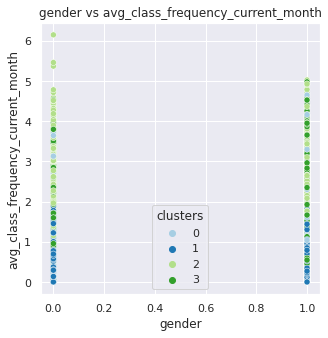

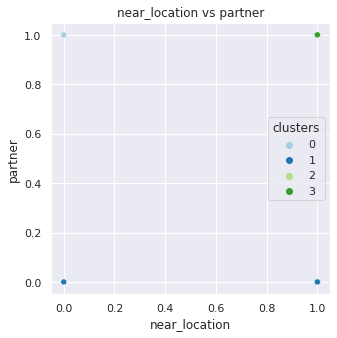

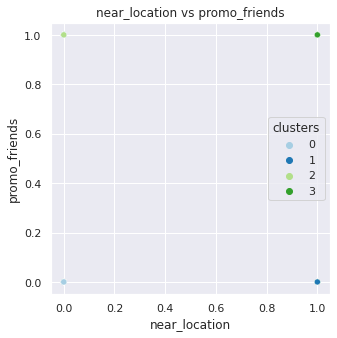

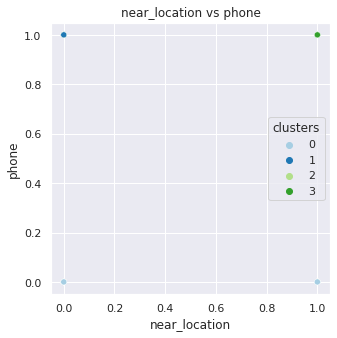

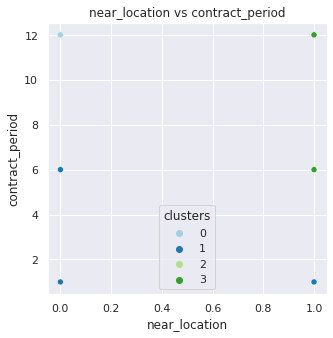

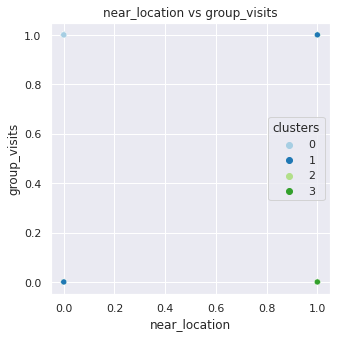

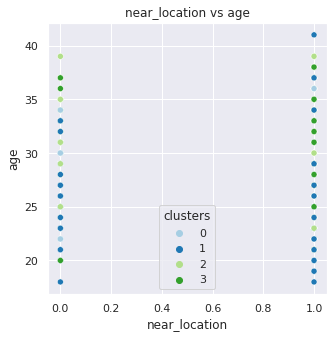

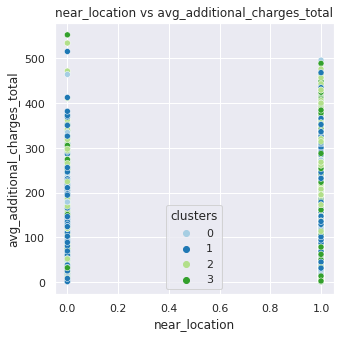

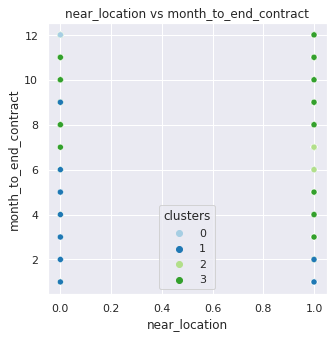

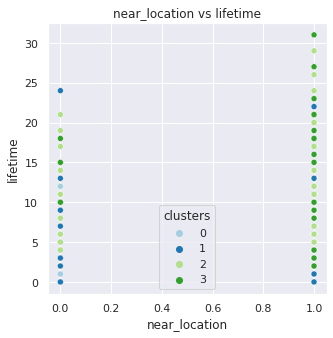

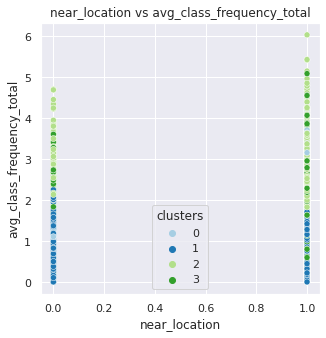

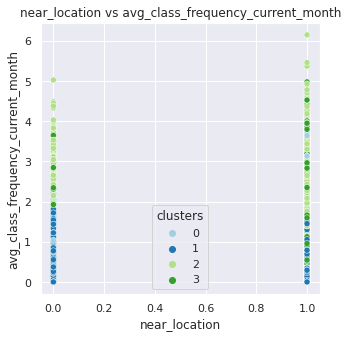

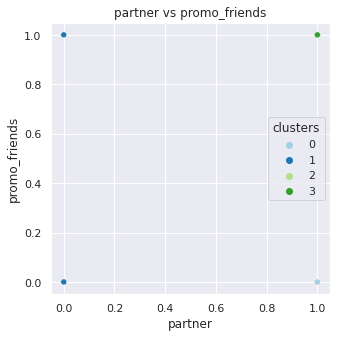

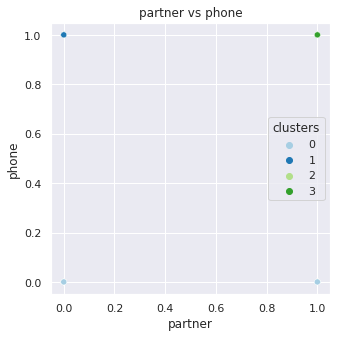

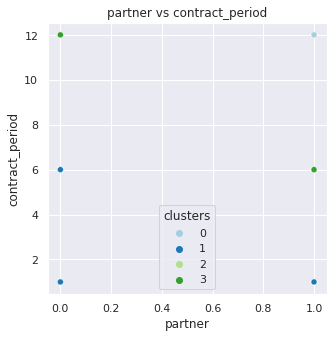

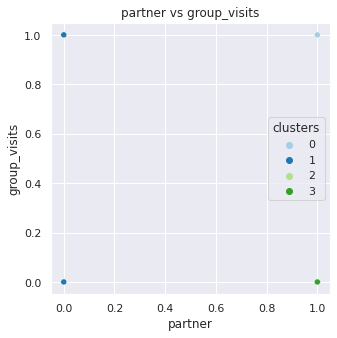

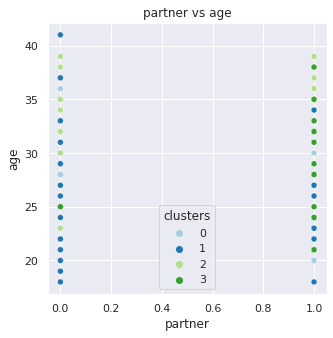

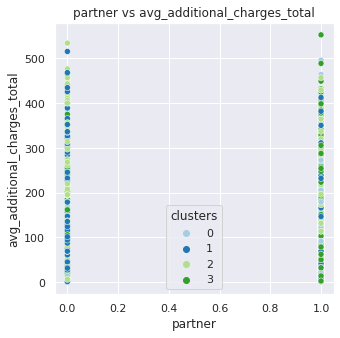

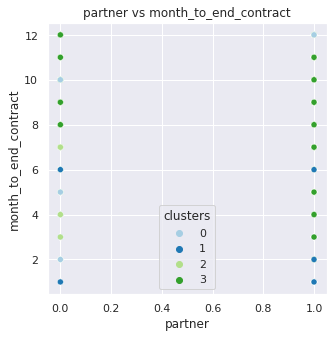

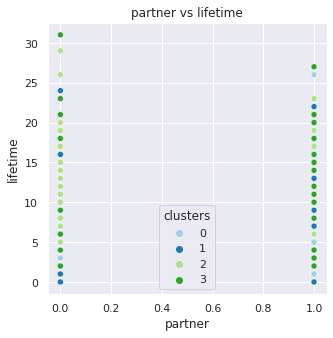

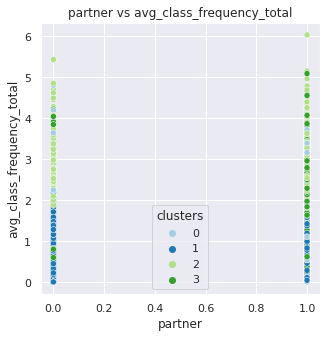

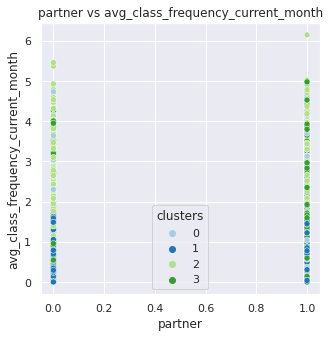

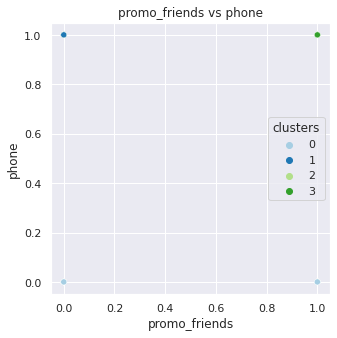

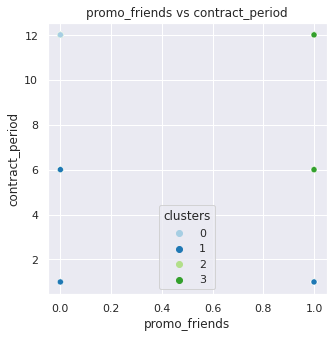

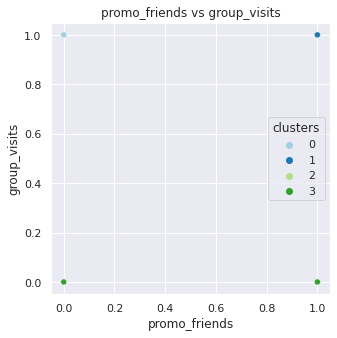

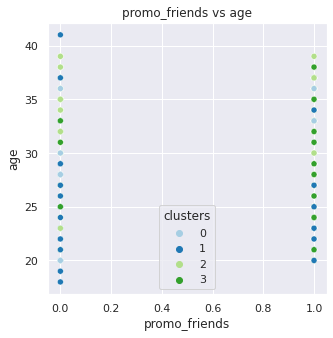

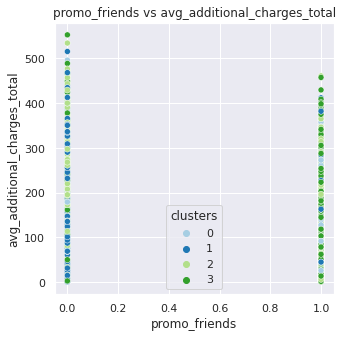

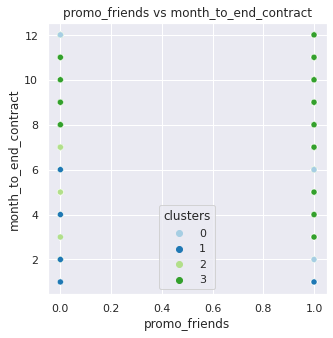

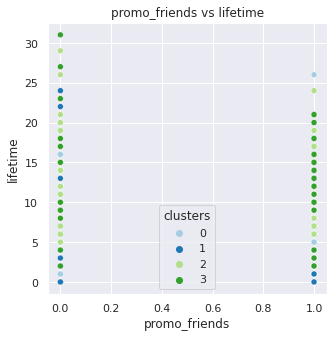

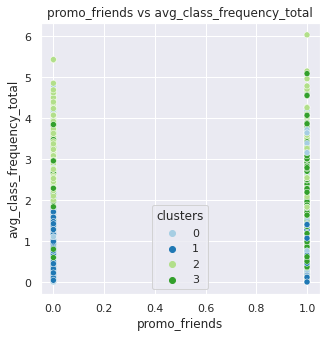

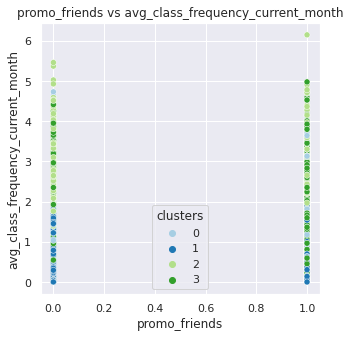

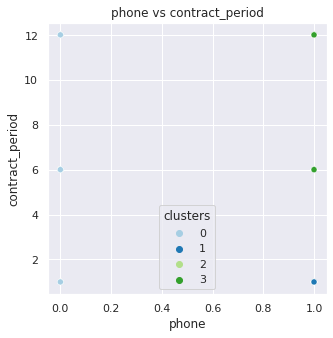

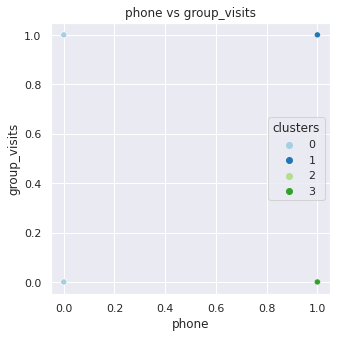

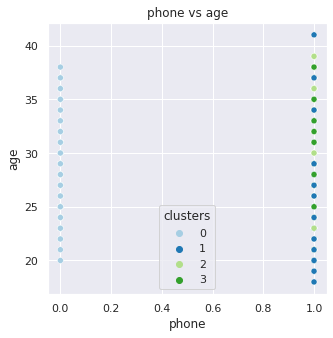

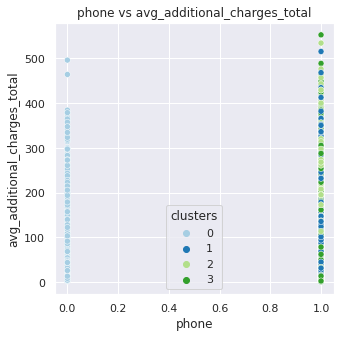

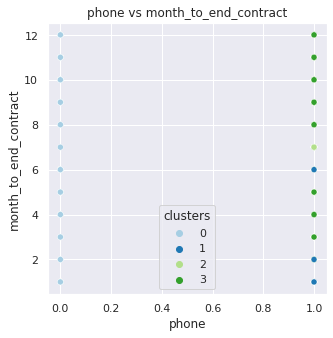

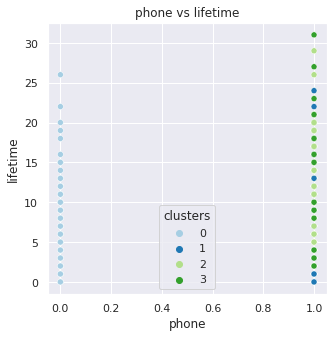

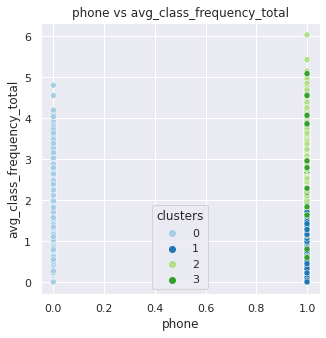

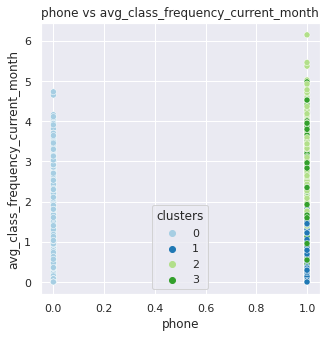

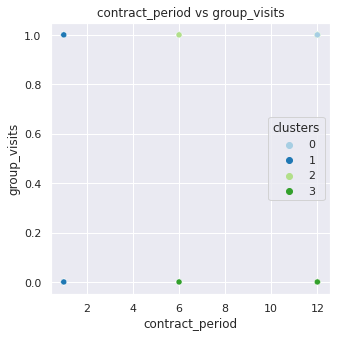

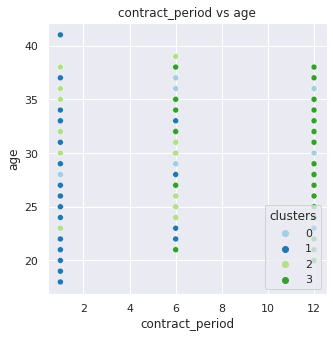

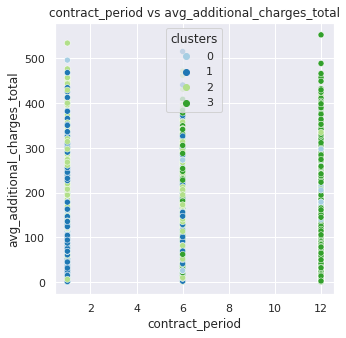

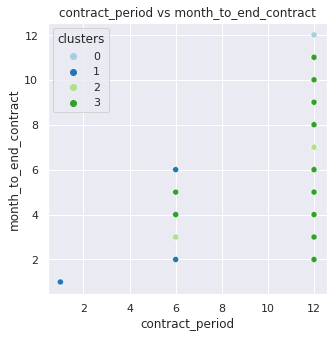

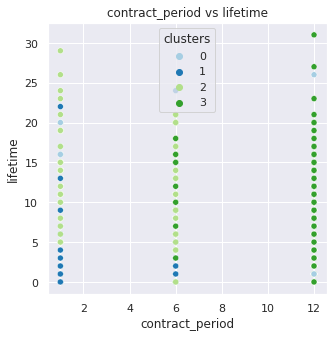

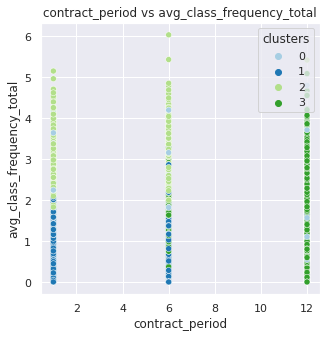

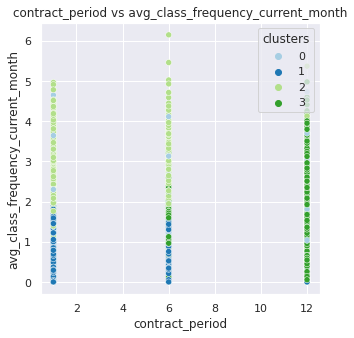

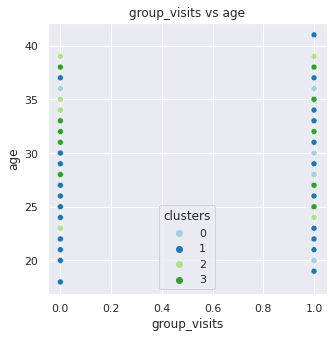

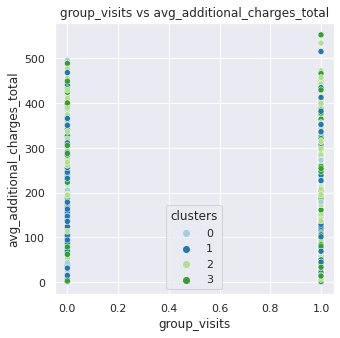

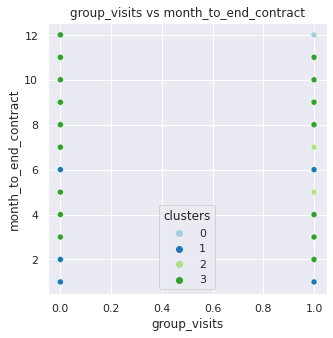

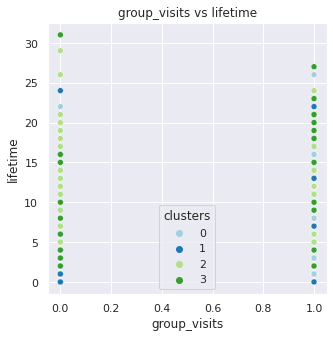

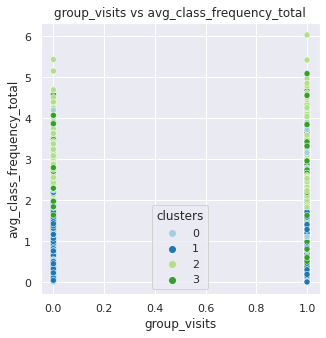

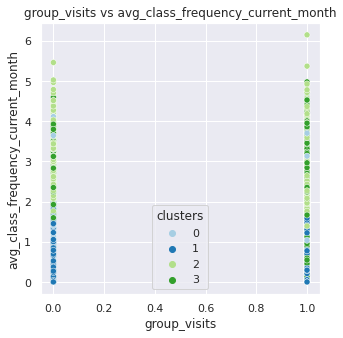

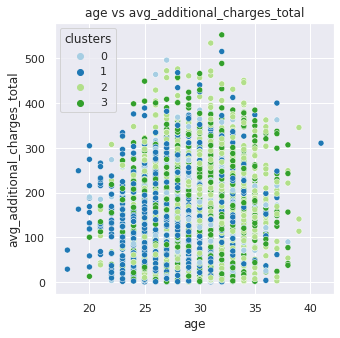

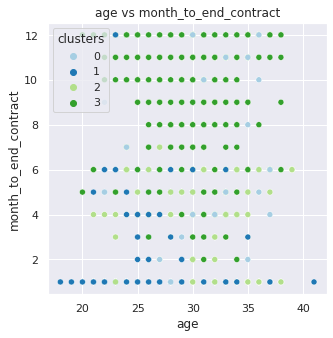

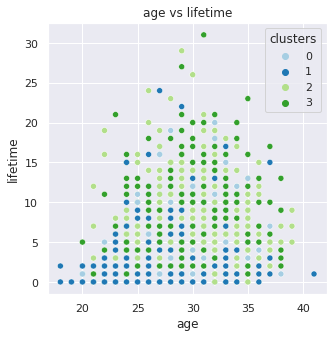

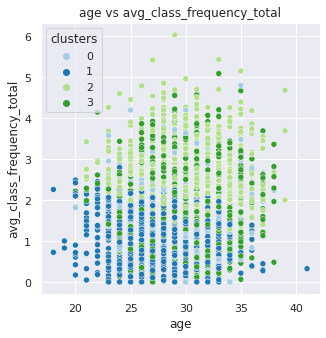

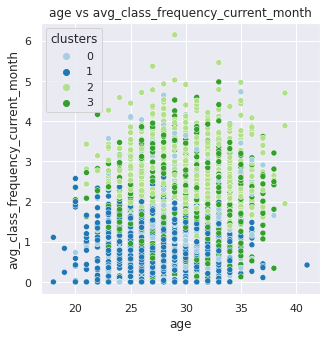

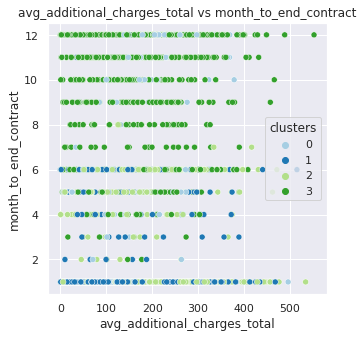

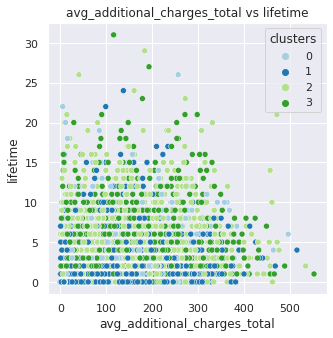

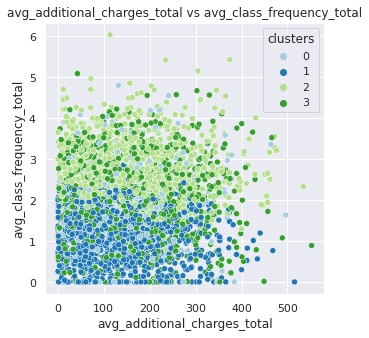

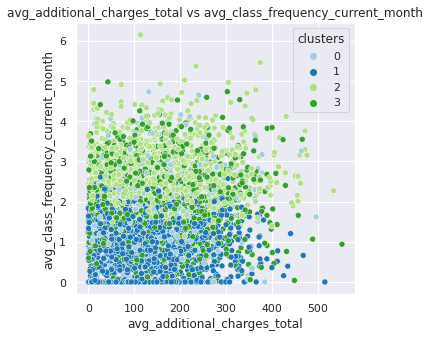

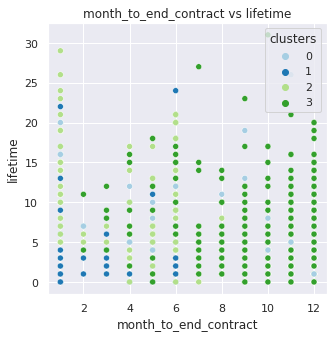

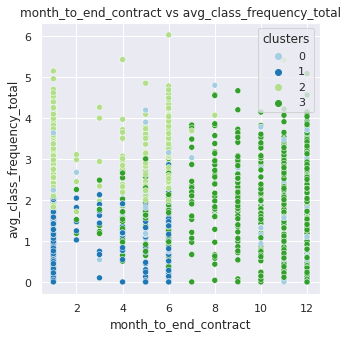

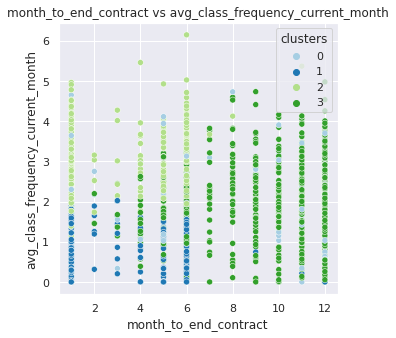

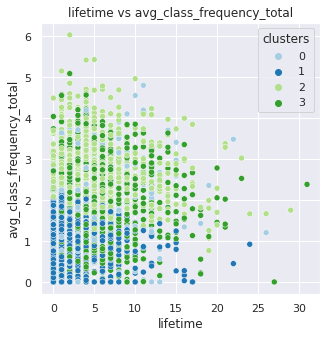

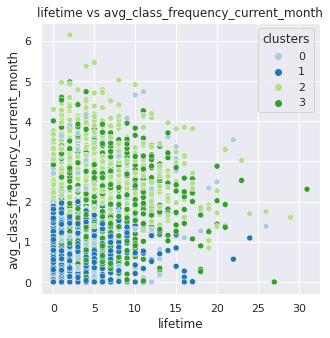

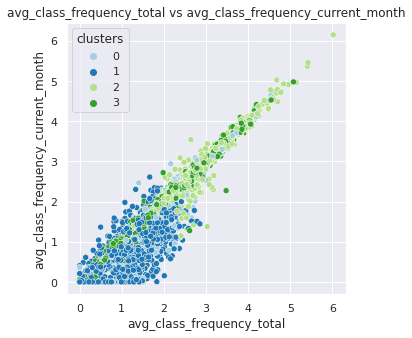

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
clusters,,,,,,,,,,,,,
0,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967
1,0.486815,0.759297,0.381339,0.190669,1.0,1.899256,0.292765,28.048005,129.704525,1.805274,2.235294,1.204610,0.951590
2,0.544939,0.861873,0.343425,0.205298,1.0,2.403027,0.447493,29.989593,157.358764,2.239357,4.704825,2.724796,2.711132
3,0.503711,0.940631,0.777365,0.572356,1.0,10.697588,0.536178,29.912801,161.363032,9.768089,4.730056,1.983884,1.975592


In [ ]:
# построим матрицы расстояний
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()
# задаём модель k_means с числом кластеров 4 и фиксируем значение random_state
KM_model = KMeans(n_clusters=4, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = KM_model.fit_predict(std_df)

# сохраняем метки кластера в поле нашего датасета
df_drop_churn['clusters'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
clusters = df_drop_churn.groupby(['clusters']).mean()


# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам
col_pairs = list(itertools.combinations(df_drop_churn.drop('clusters', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(df_drop_churn, pair[0], pair[1], 'clusters')
display(clusters)

In [ ]:
# посчитаем долю оттока для кластеров
total = pd.merge(df, df_drop_churn, on = ['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'group_visits', 'age', 'avg_additional_charges_total',
       'month_to_end_contract', 'lifetime', 'avg_class_frequency_total',
       'avg_class_frequency_current_month'])
group_by_cluster = total.groupby(['clusters']).agg({'churn':'mean'}).reset_index()
display(group_by_cluster)
display(df_drop_churn.groupby('clusters').mean().reset_index())


,clusters,churn
0,0,0.027723
1,1,0.267532
2,2,0.443564
3,3,0.514263
4,4,0.068019


,clusters,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789
1,1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369
2,2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324
3,3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983
4,4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161


## Вывод

Кластер 0 показывает лучшие результаты по оттоку клиентов 2,77%, чуть хуже показатели у кластера 4 на уровне 6,8%.  
Основные параметры лояльного клиента:  
Человек в возрасте около 30 лет, проживающий недалеко, посещающий зал около двух раз в неделю, периодически посещающий групповые занятия, пользуюется доп. услугами, владеет годовым абонементом, пришедший по партнерской программе.

Худшие показатели у кластеров 3 и 2 (51,4% и 44,35% соответственно).  
Основные параметры нелояльного клиента:
Человек моложе 30 лет, посещающий клуб не чаще раза в неделю, владелец абонемента длительностью около двух месяцев, не склонный к групповым занятиям.

## Общий вывод
Были проанализированы данные клиентов фитнес центра. На основании имеющихся данных было построено две модели прогнозирования оттока клиентов: логистическая регрессия и случайный лес.  
Основываясь на показаниях ключевых метрик оценки моделей accurancy, precision и recall можно сказать, что обе модели хорошо показывает себя в прогнозировании оттока. По совокупности чуть лучше показывает себя модель Логистическая регрессия.  

Затем была проведена кластеризация клиентов. Построенная дендрограмма показала 4 явных кластера, согласно заданию, выборку разделили на 5 кластеров. Построили распределение признаков по кластерам, на основании которых построили портрет лояльного и ненадежного клиента.

**Рекомендации отделу маркетинга**
1. Сконцентрировать усилия на меркетинге в прилегающих районах.  
2. Привлекать людей через партнерскую программу.  
3. Развивать направление групповых тренировки.  
4. Развивать направление дополнительных услуг.
5. Предлагать клиентам более продолжительные абонементы.  